# Objective
The goal with this project is to identify the best sources of protein, protein/kcal and the resulting cost effectiveness. My climbing friends and I want to find out what to buy when going on climbing trip, while on a budget.

Initial analysis will have a product selection based on cheapest options in various categories, pasta, chicken, tofu, etc.

## Tools
* Dataframes: Pandas
* Visualizations: Pandas, Matplotlib, Seaborn
* Scraping: BeautifulSoup, Request(re)
* Dashboards: Tableau

## Questions that we will answer
* What does protein contents look like in different products
* What amount of kcal do the products contain
* What do the products cost
* What is their cost/protein ration
* What is their cost/kcal ration
* What is their protein/kcal ration

## Question we won't answer, and limitations
* We will only look at data from Ica in Skärholmen and Liljeholmen
* The prices do not account for discounts
* Not a complete or balanced diet
* Not accounting for taste
* Not all products have a Kg/L price and won’t be counted
* Only comparing the given products

# Init notebook

Importing the tools and defining functions 

In [66]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
import re
import pygsheets
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
keypath = 'C:\\Users\Kaspe\Documents\AuthKeys\superfoods-383120-9880791a7067.json'
gc = pygsheets.authorize(service_file=keypath)
sh = gc.open("Super Foods")

# Scraping config

### Both prices we got had the same cleaning needs

In [6]:
def CleanPrice(numElement):
    numElement = numElement.get_text().strip().replace(u'\xa0', u' ')
    numElement = numElement.replace(u',', u'.')
    x = re.findall("\d+\.\d+", numElement)
    if(x):
        numElement = re.findall("\d+\.\d+", numElement)[0]
        return numElement
    else:
        return 0

### Scraping function

In [7]:
def InsertIcaProduct(df, url):
    response = requests.get(url)
    soup_data = BeautifulSoup(response.text, 'html.parser')
    
    soup = BeautifulSoup(response.content, "html.parser")
    dom = etree.HTML(str(soup))
    
    title = dom.xpath('/html/body/div[1]/div/div[1]/div[2]/main/div/div[1]/div/div[2]/div[1]/div[1]/h1')[0].text
    
    kg_price = soup_data.findAll('span', {"class": "text__Text-sc-6l1yjp-0 bhymDA"})
    if(kg_price):
        if('st' in str(kg_price[1])):
            print('found unit price')
            kg_price = pd.NA
        else:
            kg_price = CleanPrice(kg_price[1])
    
    price = soup_data.findAll('div', {"class" : "spacing__Spacing-sc-ngu0v9-0 lbarHM"})
    if(price):
            price = CleanPrice(price[0])
    
    contents = soup_data.findAll('div', {"class": "static-content-wrapper__StaticContentWrapper-sc-3z5iao-0 fdAbME"})
    contents.reverse()

    content_ls = contents[0].text.strip().split(",")
    key_words = ['kcal', 'kJ','Fett','mättat','Kolhydrat','socker','Fiber','Protein','Salt']
    
    for idx in range(len(key_words)):
        if(key_words[idx] not in contents[0].text):
            content_ls.insert(idx, '0')
        if(content_ls[idx]):
            x = re.findall(r'\d+(?:\.\d+)?', content_ls[idx])
            if(x):
                content_ls[idx] = x[0]

    df.loc[len(df)] = [title, content_ls[0],content_ls[1],content_ls[2],content_ls[3],content_ls[4],content_ls[5],content_ls[6],content_ls[7],content_ls[8], kg_price, price, url]
    return [df]

### Scraping

In [8]:
df = pd.DataFrame(columns=['product','kcal', 'kj', 'fat_g','sat_fat_g', 'carb_g', 'sugar_g', 'fiber_g','protein_g','salt_g', 'kg_price_kr', 'price_kr','link'])

for value in sh[1].get_all_values():
    if(value[0]!=''):
        InsertIcaProduct(df, value[0])

# Remove rows with NaN
df = df.dropna()
df.tail()

found unit price
found unit price


,product,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,link
43,Plantgurt Sojaprodukt Vanilj Laktosfri 750ml A...,66,279,2.2,0.4,7.4,7.4,0.8,3.7,0.13,39.93,29.95,https://handlaprivatkund.ica.se/stores/1003422...
44,Blomkål Fryst 600g ICA,20,90,0.1,0.1,3,1,2,1,0.1,46.58,27.95,https://handlaprivatkund.ica.se/stores/1003417...
45,Broccoli Fryst 1kg ICA Basic,20,100,0.5,0,1.8,1.6,2.3,2.4,0,31.95,31.95,https://handlaprivatkund.ica.se/stores/1003417...
46,Mjölig tvättad potatis 2kg Klass 1 ICA,250,1050,23,1.6,9.7,8.3,0,0.4,0.1,19.48,38.95,https://handlaprivatkund.ica.se/stores/1003417...
47,Fast potatis 2kg Klass 1 ICA,280,1200,27,2,8.5,7,0,0.8,0.4,19.48,38.95,https://handlaprivatkund.ica.se/stores/1003417...


### Saving results

In [9]:
# Export to google sheet and local csv 
df.to_csv('scraped_foods.csv')

wks = sh[0]
wks.set_dataframe(df,(1,1))

# Cleaning

In [10]:
super_foods = df
super_foods.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 0 to 47
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product      46 non-null     object
 1   kcal         46 non-null     object
 2   kj           46 non-null     object
 3   fat_g        46 non-null     object
 4   sat_fat_g    46 non-null     object
 5   carb_g       46 non-null     object
 6   sugar_g      46 non-null     object
 7   fiber_g      46 non-null     object
 8   protein_g    46 non-null     object
 9   salt_g       46 non-null     object
 10  kg_price_kr  46 non-null     object
 11  price_kr     46 non-null     object
 12  link         46 non-null     object
dtypes: object(13)
memory usage: 5.0+ KB


In [11]:
super_foods.head()

,product,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,link
0,Tortiglioni 400g Zeta,367,1555,1.5,0.5,73,3,2.5,14,0,57.38,22.95,https://handlaprivatkund.ica.se/stores/1003417...
1,Kycklingfilé Fryst 1kg Kronfågel,90,400,1.5,0.5,0.5,0.5,0,19,0.6,119.95,119.95,https://handlaprivatkund.ica.se/stores/1003417...
2,Tofu Naturell Ekologisk 400g YiPin,118,494,5.9,1.1,2.1,0.2,0,14.2,0.01,84.88,33.95,https://handlaprivatkund.ica.se/stores/1003417...
3,Tofu naturell 400g ICA Basic,116,483,5.8,1,0.5,0.5,0,15,0.03,62.38,24.95,https://handlaprivatkund.ica.se/stores/1003417...
4,Tofu Naturell Ekologisk 270g KRAV Kung Markatta,148,615,8.6,1.4,1.6,0.1,1.7,15,0.1,110.93,29.95,https://handlaprivatkund.ica.se/stores/1003417...


### Reordering and formating

In [12]:
super_foods = super_foods.set_index('product')
super_foods = super_foods.drop(['link'], axis=1)
super_foods = super_foods.astype('float64')

In [13]:
# Createing new columns
super_foods['hg_price_kr'] = super_foods.kg_price_kr/10
super_foods['kcal_per_kr'] = super_foods.kcal/super_foods.hg_price_kr
super_foods['prot_per_kr'] = super_foods.protein_g/super_foods.hg_price_kr
super_foods['prot_per_kcal'] = super_foods.protein_g/super_foods.kcal

# Remove any rows that didn't have enough data, which results on NaN
super_foods = super_foods.dropna()

In [14]:
super_foods.head()

,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,hg_price_kr,kcal_per_kr,prot_per_kr,prot_per_kcal
product,,,,,,,,,,,,,,,
Tortiglioni 400g Zeta,367.0,1555.0,1.5,0.5,73.0,3.0,2.5,14.0,0.00,57.38,22.95,5.738,63.959568,2.439875,0.038147
Kycklingfilé Fryst 1kg Kronfågel,90.0,400.0,1.5,0.5,0.5,0.5,0.0,19.0,0.60,119.95,119.95,11.995,7.503126,1.583993,0.211111
Tofu Naturell Ekologisk 400g YiPin,118.0,494.0,5.9,1.1,2.1,0.2,0.0,14.2,0.01,84.88,33.95,8.488,13.901979,1.672950,0.120339
Tofu naturell 400g ICA Basic,116.0,483.0,5.8,1.0,0.5,0.5,0.0,15.0,0.03,62.38,24.95,6.238,18.595704,2.404617,0.129310
Tofu Naturell Ekologisk 270g KRAV Kung Markatta,148.0,615.0,8.6,1.4,1.6,0.1,1.7,15.0,0.10,110.93,29.95,11.093,13.341747,1.352204,0.101351


## Analysis

<Axes: title={'center': 'Protein / kr'}, ylabel='product'>

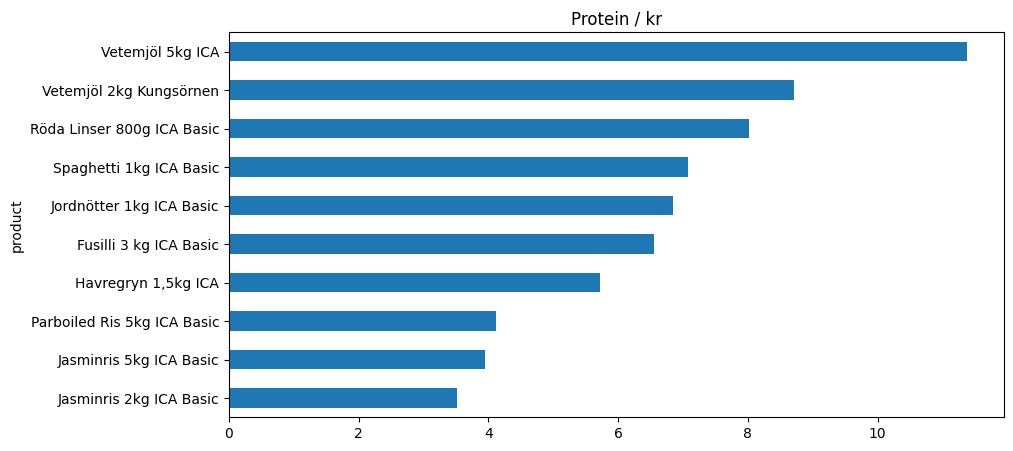

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.prot_per_kr.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Protein / kr")

<Axes: title={'center': 'Kcal / kr'}, ylabel='product'>

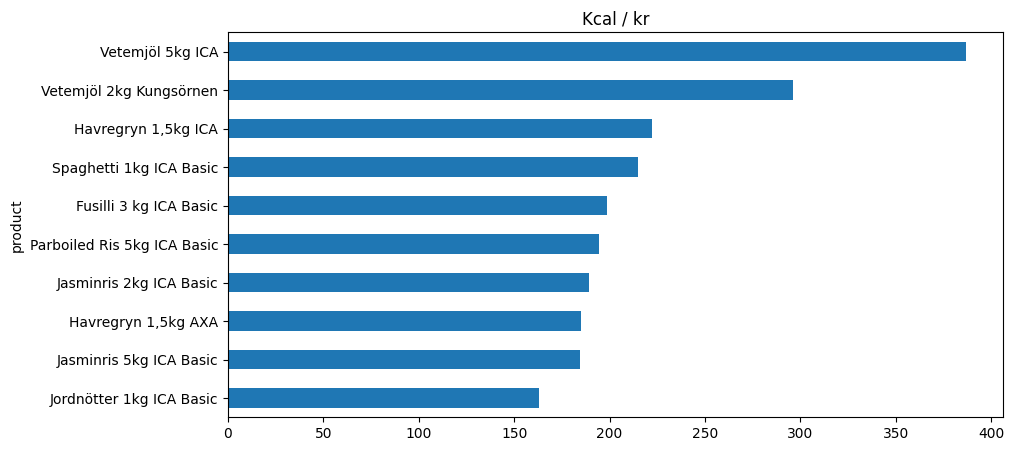

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.kcal_per_kr.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Kcal / kr")

<Axes: title={'center': 'Protein / kcal'}, ylabel='product'>

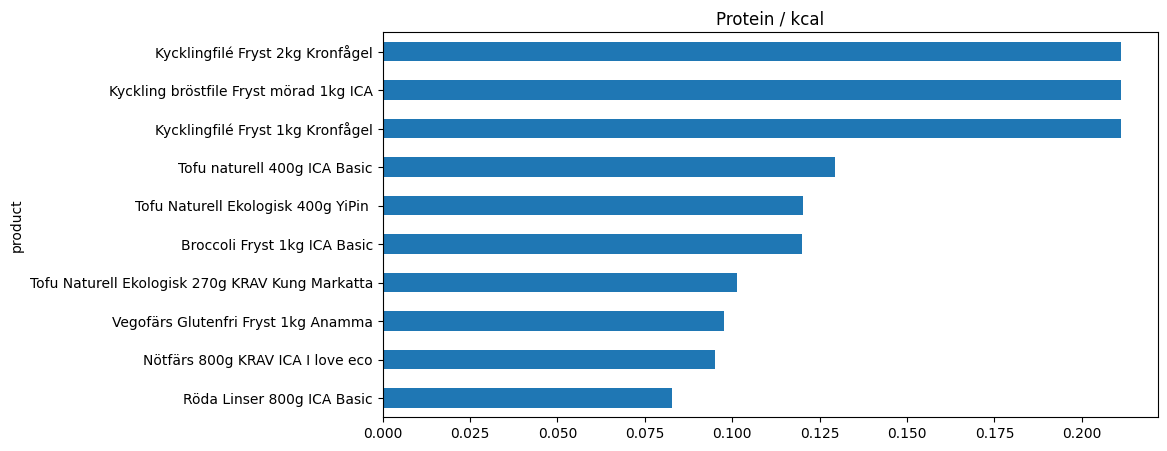

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.prot_per_kcal.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Protein / kcal")

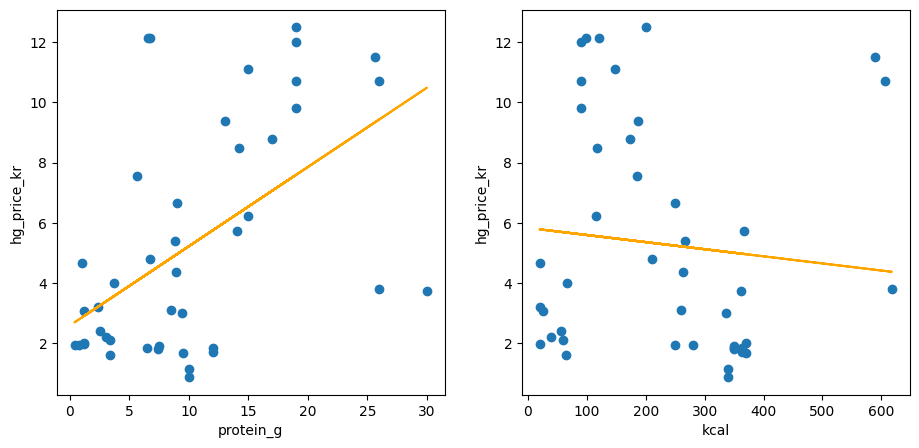

In [113]:
# Protein/kg_price
fig, axs = plt.subplots(1,2,figsize=(11,5))
axs[0].scatter(x=super_foods.protein_g, y=super_foods.hg_price_kr, label=True)
axs[0].set(xlabel="protein_g")
axs[0].set(ylabel="hg_price_kr")

m, b = np.polyfit(super_foods.protein_g, super_foods.hg_price_kr, 1)
axs[0].plot(super_foods.protein_g, m*super_foods.protein_g+b, color='Orange')

# Kcal/kr
axs[1].scatter(x=super_foods.kcal, y=super_foods.hg_price_kr, label=True)
axs[1].set(xlabel="kcal")
axs[1].set(ylabel="hg_price_kr")

m, b = np.polyfit(super_foods.kcal, super_foods.hg_price_kr, 1)
axs[1].plot(super_foods.kcal, m*super_foods.kcal+b, color='Orange')

plt.show()

## Outliers

We see 3 calues on the kcal plot that contain an unusual amount of kcal, so we'll isolate them to see what they are. Turns out it's peanut based foods

In [120]:
super_foods.sort_values(by='kcal', ascending=False).kcal.head(3)

product
Jordnötter 1kg ICA Basic                      618.0
Jordnötssmör Crunchy 700g ICA I love eco      606.0
Jordnötssmör Crunchy 1kg KRAV Green Choice    589.7
Name: kcal, dtype: float64

AttributeError: PathCollection.set() got an unexpected keyword argument 'title'

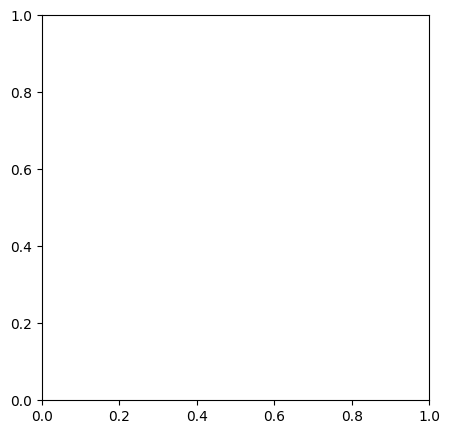

In [141]:
fig = plt.figure(figsize=(5,5))

# Protein/Kcal
plt.scatter(x=super_foods.protein_g, y=super_foods.kcal)
plt.xlabel("protein_g")
plt.ylabel = "kcal"

m, b = np.polyfit(super_foods.protein_g, super_foods.kcal, 1)
plt.plot(super_foods.protein_g, m*super_foods.protein_g+b, color='Orange')
plt.show()


# Conclusion
With this new information we can deduce that flour is really good if you're on a budget.
If you're looking for protein on a caloric deficit, chicken, tofu, Broccoli and vegie/minced meat are all good options.

## Example dishes
A cheap dish I could make for an upcoming adventure would be spicy lentils stew with some pasta.
If maintaining a caloric deficit with good protein intake is the goal. I would fry chicken (or tofu for veggie option), together with either rice or pasta and some tomato sauce